In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ta  # Technical analysis library

In [36]:

data = yf.download('AAPL', period='2y', interval='1d')
data.tail()

C:\Users\seana\AppData\Local\Temp\ipykernel_15264\3852257194.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download('AAPL', period='2y', interval='1d')
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2025-07-24,213.759995,215.690002,213.529999,213.899994,46022600
2025-07-25,213.880005,215.240005,213.399994,214.699997,40268800
2025-07-28,214.050003,214.850006,213.059998,214.029999,37858000
2025-07-29,211.270004,214.809998,210.820007,214.179993,51411700
2025-07-30,209.050003,212.389999,207.720001,211.899994,43797200


In [37]:
# Calculate RSI (14-day window)
data[('RSI', 'AAPL')] = ta.momentum.RSIIndicator(close=data[( 'Close', 'AAPL')], window=14).rsi()
print(data[['Close', 'RSI']].tail())

KeyError: "['(Close'] not in index"

In [38]:
data[('RSI', 'AAPL')]

Date
2023-07-31          NaN
2023-08-01          NaN
2023-08-02          NaN
2023-08-03          NaN
2023-08-04          NaN
                ...    
2025-07-24    62.914016
2025-07-25    63.143004
2025-07-28    63.486928
2025-07-29    54.526394
2025-07-30    48.624420
Name: (RSI, AAPL), Length: 502, dtype: float64

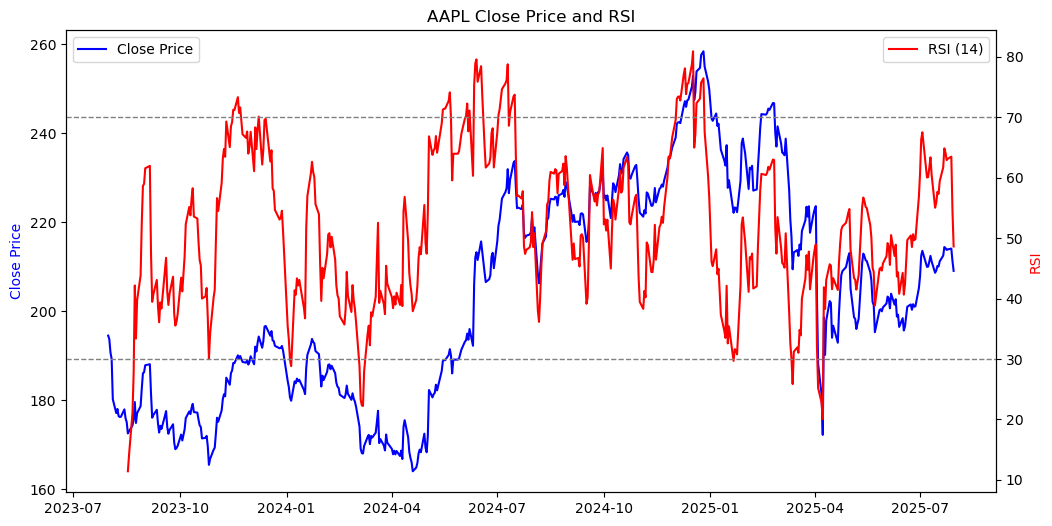

In [39]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12,6))

ax1.plot(data.index, data[('Close', 'AAPL')], color='blue', label='Close Price')
ax1.set_ylabel('Close Price', color='blue')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(data.index, data[('RSI', 'AAPL')], color='red', label='RSI (14)')
ax2.set_ylabel('RSI', color='red')
ax2.axhline(70, color='gray', linestyle='--', linewidth=1)
ax2.axhline(30, color='gray', linestyle='--', linewidth=1)
ax2.legend(loc='upper right')

plt.title('AAPL Close Price and RSI')
plt.show()

In [40]:
# Calculate MACD and Signal line
macd = ta.trend.MACD(close=data[('Close', 'AAPL')])

# Add MACD, Signal, and Histogram to your DataFrame
data[('MACD', 'AAPL')] = macd.macd()
data[('MACD_Signal', 'AAPL')] = macd.macd_signal()
data[('MACD_Hist', 'AAPL')] = macd.macd_diff()

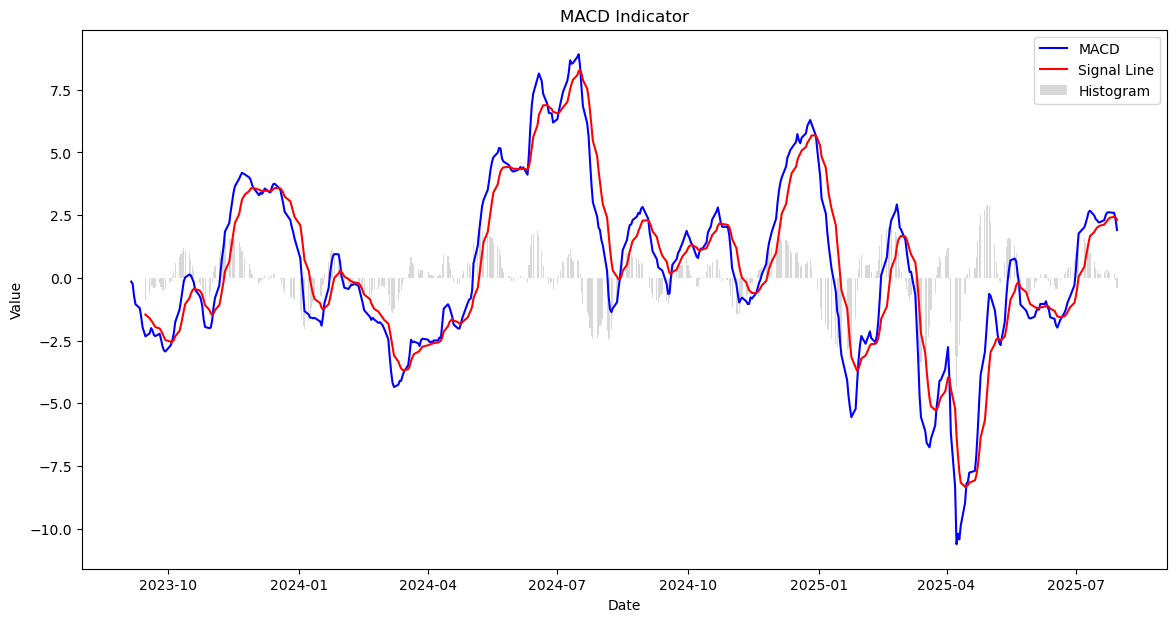

In [41]:
plt.figure(figsize=(14, 7))

# Plot MACD and Signal line
plt.plot(data.index, data[('MACD', 'AAPL')], label='MACD', color='blue')
plt.plot(data.index, data[('MACD_Signal', 'AAPL')], label='Signal Line', color='red')

# Plot Histogram
plt.bar(data.index, data[('MACD_Hist', 'AAPL')], label='Histogram', color='gray', alpha=0.3)

plt.title('MACD Indicator')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

In [42]:
data[('SMA50', 'AAPL')] = data[('Close', 'AAPL')].rolling(window=50).mean()

In [74]:
# Initialize scores
buy_scores = []
sell_scores = []

for i in range(1, len(data)):
    # Individual indicator signals
    rsi_buy = data[('RSI', 'AAPL')].iloc[i] < 30
    rsi_sell = data[('RSI', 'AAPL')].iloc[i] > 70

    macd_buy = (
        data[('MACD', 'AAPL')].iloc[i] > data[('MACD_Signal', 'AAPL')].iloc[i] and
        data[('MACD', 'AAPL')].iloc[i-1] <= data[('MACD_Signal', 'AAPL')].iloc[i-1]
    )
    macd_sell = (
        data[('MACD', 'AAPL')].iloc[i] < data[('MACD_Signal', 'AAPL')].iloc[i] and
        data[('MACD', 'AAPL')].iloc[i-1] >= data[('MACD_Signal', 'AAPL')].iloc[i-1]
    )

    sma_buy = (
        data[('Close', 'AAPL')].iloc[i] > data[('SMA50', 'AAPL')].iloc[i] and
        data[('Close', 'AAPL')].iloc[i-1] <= data[('SMA50', 'AAPL')].iloc[i-1]
    )
    sma_sell = (
        data[('Close', 'AAPL')].iloc[i] < data[('SMA50', 'AAPL')].iloc[i] and
        data[('Close', 'AAPL')].iloc[i-1] >= data[('SMA50', 'AAPL')].iloc[i-1]
    )

    # Sum up the number of buy/sell signals
    buy_score = int(rsi_buy) + int(macd_buy) + int(sma_buy)
    sell_score = int(rsi_sell) + int(macd_sell) + int(sma_sell)

    buy_scores.append(buy_score)
    sell_scores.append(sell_score)

# Pad the first row
buy_scores = [0] + buy_scores
sell_scores = [0] + sell_scores

data[('Buy_Score', 'AAPL')] = buy_scores
data[('Sell_Score', 'AAPL')] = sell_scores

# Example: Show days where at least 2 out of 3 indicators agree
print("Strong Buy signals (2 or more):")
print(data[data[('Buy_Score', 'AAPL')] >= 1][['Close', 'RSI', 'MACD', 'MACD_Signal', 'SMA50', 'Buy_Score']])

print("\nStrong Sell signals (2 or more):")
print(data[data[('Sell_Score', 'AAPL')] >= 1][['Close', 'RSI', 'MACD', 'MACD_Signal', 'SMA50', 'Sell_Score']])

Strong Buy signals (2 or more):
Price            Close        RSI       MACD MACD_Signal       SMA50 Buy_Score
Ticker            AAPL       AAPL       AAPL        AAPL        AAPL      AAPL
Date                                                                          
2023-08-17  172.507767  11.420883        NaN         NaN         NaN         1
2023-08-18  172.993591  14.081335        NaN         NaN         NaN         1
2023-08-21  174.331970  21.110855        NaN         NaN         NaN         1
2023-08-22  175.710083  27.672767        NaN         NaN         NaN         1
2023-10-04  172.170685  44.127081  -2.477086   -2.540299         NaN         1
2023-10-11  178.258011  56.526715  -0.524252   -1.606914  176.811209         1
2023-11-02  176.047134  56.626253  -1.154454   -1.406542  175.068023         2
2023-12-08  194.287231  70.111386   3.562010    3.475000  180.018663         1
2023-12-13  196.520859  69.554265   3.607276    3.484525  181.392021         1
2024-01-04  180.5875

In [81]:
data.columns

MultiIndex([(      'Close', 'AAPL'),
            (       'High', 'AAPL'),
            (        'Low', 'AAPL'),
            (       'Open', 'AAPL'),
            (     'Volume', 'AAPL'),
            (        'RSI', 'AAPL'),
            (       'MACD', 'AAPL'),
            ('MACD_Signal', 'AAPL'),
            (  'MACD_Hist', 'AAPL'),
            (      'SMA50', 'AAPL'),
            (  'Buy_Score', 'AAPL'),
            ( 'Sell_Score', 'AAPL')],
           names=['Price', 'Ticker'])

In [83]:
import numpy as np

# Get the indices (dates) of buy and sell signals
buy_dates = data.index[data[('Buy_Score', 'AAPL')] >= 2].tolist()
sell_dates = data.index[data[('Sell_Score', 'AAPL')] >= 2].tolist()

# Ensure buy and sell dates are sorted
buy_dates.sort()
sell_dates.sort()

trades = []
in_position = False
sell_idx = 0
i = 0

while i < len(buy_dates):
    buy_date = buy_dates[i]
    # Only buy if not already in a position
    if not in_position:
        # Find the first sell date after the buy date
        while sell_idx < len(sell_dates) and sell_dates[sell_idx] <= buy_date:
            sell_idx += 1
        if sell_idx < len(sell_dates):
            sell_date = sell_dates[sell_idx]
            # Get the next day's open price for buy and sell
            # Make sure we don't go out of bounds
            buy_loc = data.index.get_loc(buy_date)
            sell_loc = data.index.get_loc(sell_date)
            if buy_loc + 1 < len(data) and sell_loc + 1 < len(data):
                buy_exec_date = data.index[buy_loc + 1]
                sell_exec_date = data.index[sell_loc + 1]
                buy_price = data.loc[buy_exec_date, ('High', 'AAPL')]
                sell_price = data.loc[sell_exec_date, ('Low', 'AAPL')]
                return_pct = (sell_price - buy_price) / buy_price
                trades.append({
                    'Buy Signal Date': buy_date,
                    'Buy Exec Date': buy_exec_date,
                    'Sell Signal Date': sell_date,
                    'Sell Exec Date': sell_exec_date,
                    'Buy Price': buy_price,
                    'Sell Price': sell_price,
                    'Return %': return_pct * 100
                })
                in_position = False  # Will be set to False after the trade
                # Move to the next sell signal for the next trade
                sell_idx += 1
                # Skip any buy signals that occur before this sell signal
                while i + 1 < len(buy_dates) and buy_dates[i + 1] <= sell_date:
                    i += 1
            else:
                # If we can't get the next day's open, break
                break
    i += 1

# Convert to DataFrame for easy viewing
trades_df = pd.DataFrame(trades)

# Calculate total and average return
total_return = (np.prod(1 + trades_df['Return %'] / 100) - 1) * 100 if not trades_df.empty else 0
average_return = trades_df['Return %'].mean() if not trades_df.empty else 0

print(trades_df)
print(f"\nTotal compounded return: {total_return:.2f}%")
print(f"Average return per trade: {average_return:.2f}%")

  Buy Signal Date Buy Exec Date Sell Signal Date Sell Exec Date   Buy Price  \
0      2023-11-02    2023-11-03       2024-09-04     2024-09-05  175.303596   

   Sell Price   Return %  
0  220.744056  25.921008  

Total compounded return: 25.92%
Average return per trade: 25.92%


In [73]:
# Define your ticker and column
ticker = 'AAPL'
close_col = ('Close', ticker)

# Get the buy and sell prices
buy_date = '2023-11-02'
sell_date = data.index[-1]  # Last date in your DataFrame

buy_price = data.loc[buy_date, close_col]
sell_price = data.loc[sell_date, close_col]

# Calculate return
return_pct = (sell_price - buy_price) / buy_price * 100

print(f"Buy-and-hold from {buy_date} to {sell_date}:")
print(f"  Buy Price:  {buy_price:.2f}")
print(f"  Sell Price: {sell_price:.2f}")
print(f"  Return:     {return_pct:.2f}%")

Buy-and-hold from 2023-11-02 to 2025-07-30 00:00:00:
  Buy Price:  176.05
  Sell Price: 209.05
  Return:     18.75%
